In [114]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#from cartopy import config
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
import math

In [115]:
def weighted_avg(data,weights): #data must be #time, lat, lon
    return np.mean(np.average(data, axis=1, weights=weights),axis=1) #average weighted over latitude, and normal over longitude

In [116]:
#Import NetCDF PlaSim output file
file1   = 'test.nc'

#open dataset and load variables to plot
DATA    = xr.open_dataset(file1,decode_times=False)
lon     = DATA['lon'].data #1D array longitudes
lat     = DATA['lat'].data #1D array lattitudes
lev     = DATA['lev'].data #1D array of vertical levels
time    = DATA['time'].data #1D array of time 

In [50]:
# Adjusting time coordinates
datetimes = pd.date_range(start='1/1/1850',freq='D',periods=(len(time)))    
DATA['time']=datetimes
DATA.set_coords('time')
datetimes_yearly = pd.date_range(start='1/1/1850',freq='AS',periods=len(time)/360)    

#Taking the yearly average of the monthly data
tso_yearly = DATA.resample(time='1Y').mean()

#Selecting the soil temperature data
TSO_all = np.stack((tso_yearly.tso.data, tso_yearly.tso2.data, tso_yearly.tso3.data, tso_yearly.tso4.data, tso_yearly.tsod.data))
np.shape(TSO_all)
#Selecting the surface temperature data
TS=np.stack((tso_yearly.ts.data,tso_yearly.tsa.data))

#Defining a function that is able to weigh gridcells for their area due its latitude
weights_T21 = np.cos(np.deg2rad(DATA.lat)) #For a rectangular grid the cosine of the latitude is proportional to the grid cell area.

In [52]:
#Defining constants
Nlayers = 5
Nlon = len(DATA.lon)
Nlat = len(DATA.lat)
Nyears=len(tso_yearly.time)
k=0.03
RefT=273.15

In [49]:
# Count the amount of permafrost per year, and create a mask of where there is permafrost for each year
PFcount = np.zeros((Nlayers,Nyears)) #Create an array to count the amount of permafrost in the reference/starting year, after a warming up period.
PFMask = np.zeros((Nlayers,Nyears,64,32)) #Create a 'permafrost mask' for each year, which denotes a 1 where there is permafrost
PFstartlist=np.zeros(Nlayers) # Make a list for the amount of 'weighted gridcells' of permafrost per year.
dPF = np.zeros((Nlayers,Nyears,64,32))
for nlevel in range(Nlayers):
    for nyear in range(len(tso_yearly.time)):
#     for nyear in range(2):
        for nlon in range(len(DATA.lon)):
            for nlat in range(int(len(DATA.lat))):
                tsopf = TSO_all[nlevel,nyear,nlat,nlon]
                if (tsopf > 0) and (tsopf < RefT) and PFMask[nlevel, nyear-1,nlon,nlat] == 1 and nyear > 0 and nlat<16:
                    PFcount[nlevel,nyear] += 1 * np.cos(np.deg2rad(DATA.lat.isel(lat=nlat).values))
                    PFMask[nlevel,nyear,nlon,nlat] = 1
                elif (tsopf > 0) and (tsopf < RefT) and nyear == 0 and nlat<16:
                    PFcount[nlevel,nyear] += 1 * np.cos(np.deg2rad(DATA.lat.isel(lat=nlat).values))
                    PFMask[nlevel, nyear,nlon,nlat] = 1
        if nyear > 0:
            dPF[:,nyear,:,:] = PFMask[:,nyear-1,:,:] - PFMask[:,nyear,:,:]  
PFstartlist[:] = PFcount[:,50]      


In [117]:
# Function for dividing carbon over reservoirs
def carbonweight(nlat,level):
    carbonlist=[500,250,125,125,500]
    return weights_T21.isel(lat=nlat)*(carbonlist[(level)]/(PFstartlist[level]))

# Dividing all carbon over permafrost reservoirs
carbonarray = np.zeros((Nlayers,Nlat,Nlon))
refyear=50
for nlevel in range(Nlayers):
    for nlon in range(Nlon):
        for nlat in range(int(Nlat)):
            tsopf = TSO_all[nlevel,refyear,nlat,nlon]
            if (tsopf > 0) and (tsopf < RefT) and nlat < 16:
                carbonarray[nlevel,nlat,nlon] = carbonweight(nlat,nlevel)

                
# Calculating emissions from melt
carbonhistory=np.zeros((Nlayers,Nlat,Nlon,Nyears))
Epermlist=np.zeros(Nyears)
for nyear in np.arange(refyear,Nyears,1):
    Eperm=0
    for nlevel in range(Nlayers):
        for nlon in range(Nlon):
            for nlat in range(int(Nlat)):
                tsopf = TSO_all[nlevel,nyear,nlat,nlon]
                if carbonarray[nlevel,nlat,nlon]>0 and tsopf>273.15:
                    dC=k*2**((tsopf-273.15)/10)*carbonarray[nlevel,nlat,nlon]
                    carbonarray[nlevel,nlat,nlon]-=dC
                    Eperm+=dC
    carbonhistory[:,:,:,nyear]=carbonarray        
    Epermlist[nyear]=Eperm

In [118]:
# Calculating GHG emissions
CO2Cratio=44.01/12.0106 #(g/mol)/(g/mol)
CH4Cratio=16.04/12.0107 #(g/mol)/(g/mol)
CH4percentage=0.05
Eco2list=Epermlist*(1-CH4percentage)*CO2Cratio # List of permafrost CO2 emissions per year in Gt
Ech4list=Epermlist*CH4percentage*CH4Cratio # List of permafrost CH4 emissions per year in Gt

In [119]:
# GHG decay model
CO2ppmlist=np.zeros((Nyears))
CH4ppmlist=np.zeros((Nyears))
Cco2=0.47 #ppmv/GtC
t1=171 #years
t2=18 #years
t3=2.57 #years
f0=0.152 #fraction
f1=0.253 #fraction
f2=0.279 #fraction
f3=0.316 #fraction

Cch4=Cco2*CO2Cratio/CH4Cratio
halftime_ch4=8.6 #years

for nyear in range(Nyears):
    CO2=0
    CH4=0
    for nyear2 in range(nyear):
        CO2+=Eco2list[nyear2]*(f0+(f1*np.exp((nyear2-nyear)/t1))+(f2*np.exp((nyear2-nyear)/t2))+(f3*np.exp((nyear2-nyear)/t3)))
        CH4+=Ech4list[nyear2]*0.5**((nyear-nyear2)/halftime_ch4)
    CO2ppmlist[nyear]=Cco2*CO2
    CH4ppmlist[nyear]=Cch4*CH4


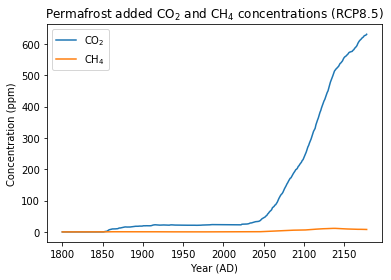

In [120]:
yearlist=np.arange(1800,1800+Nyears,1)

#Plot CO2 anc CH4 concentrations in absolute concentrations
plt.plot(yearlist,CO2ppmlist, label='CO$_2$')
plt.plot(yearlist,CH4ppmlist, label='CH$_4$')

plt.title('Permafrost added CO$_2$ and CH$_4$ concentrations (RCP8.5)')
plt.ylabel('Concentration (ppm)')
plt.xlabel('Year (AD)')
plt.legend()
plt.show()

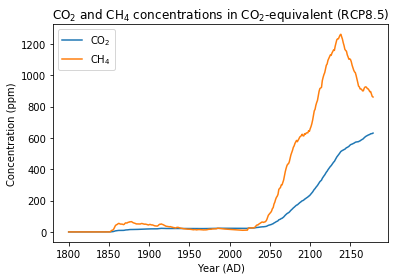

In [121]:
#Plot CO2 anc CH4 concentrations in CO2-eq.
plt.plot(yearlist,CO2ppmlist, label='CO$_2$')
plt.plot(yearlist,CH4ppmlist*110.25, label='CH$_4$')
plt.title('CO$_2$ and CH$_4$ concentrations in CO$_2$-equivalent (RCP8.5)')
plt.ylabel('Concentration (ppm)')
plt.xlabel('Year (AD)')
plt.legend()
plt.show()

In [122]:
#Create lists
modelppm=CO2ppmlist+110.25*CH4ppmlist
RCP85=pd.read_csv('CO2eqRCP8.5.csv', delimiter=';')
RCP3=pd.read_csv('CO2RCP3PD.csv', delimiter=';')

RCP85list=RCP85['ppm'].values.tolist()
RCP3list=RCP3['ppm'].values.tolist()

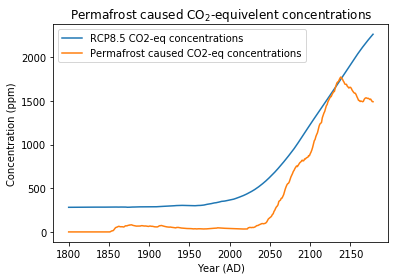

In [123]:

plt.plot(yearlist,RCP85list[35:35+Nyears],label='RCP8.5 CO2-eq concentrations')
plt.plot(yearlist,modelppm,label='Permafrost caused CO2-eq concentrations')

plt.title('Permafrost caused CO$_2$-equivelent concentrations')
plt.ylabel('Concentration (ppm)')
plt.legend()
plt.xlabel('Year (AD)')
plt.show()

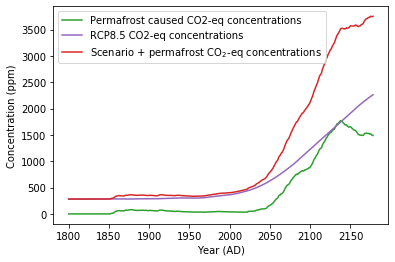

In [124]:
totalppm=np.zeros(Nyears+35)
for year in range(Nyears+35):
    if year <= 35:
        totalppm[year]=RCP85list[year]
    if year > 35:
        totalppm[year]=RCP85list[year]+modelppm[year-35]

plt.plot(yearlist,modelppm,label='Permafrost caused CO2-eq concentrations',color='tab:green')
plt.plot(yearlist,RCP85list[35:35+Nyears],label='RCP8.5 CO2-eq concentrations',color='tab:purple')
plt.plot(yearlist,totalppm[35:35+Nyears],label='Scenario + permafrost CO$_2$-eq concentrations',color='tab:red')

#plt.title('Permafrost caused CO$_2$-equivelent concentrations')
plt.ylabel('Concentration (ppm)')
plt.legend()
plt.xlabel('Year (AD)')
plt.show()

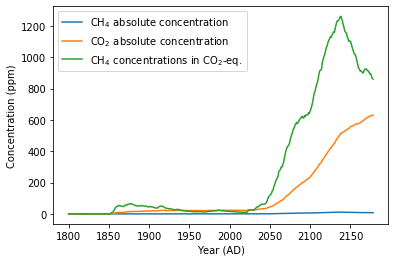

In [125]:
plt.plot(yearlist,CH4ppmlist, label='CH$_4$ absolute concentration')

plt.plot(yearlist,CO2ppmlist, label='CO$_2$ absolute concentration')
plt.plot(yearlist,CH4ppmlist*110.25, label='CH$_4$ concentrations in CO$_2$-eq.')

#plt.plot(yearlist,RCP85list[35:35+Nyears],label='RCP8.5 CO2-eq concentrations')


#plt.title('Permafrost added CO$_2$ and CH$_4$ concentrations (RCP8.5)')
plt.ylabel('Concentration (ppm)')
plt.xlabel('Year (AD)')
plt.legend()
plt.show()

In [126]:
carbonhistorylist=np.zeros(Nyears)
for nyear in range(Nyears):
    carbonhistorylist[nyear]=carbonhistory[:,:,:,nyear].sum()

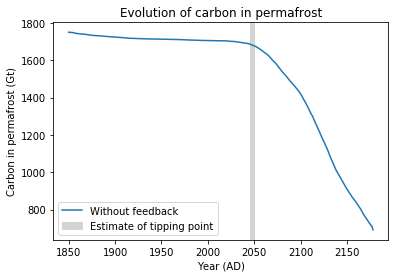

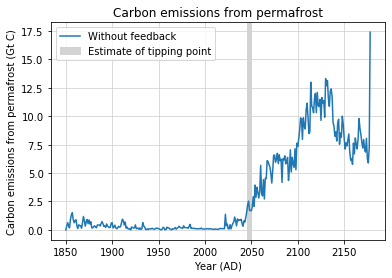

In [127]:
plt.plot(yearlist[50:],carbonhistorylist[50:],label='Without feedback')
plt.ylabel('Carbon in permafrost (Gt)')
plt.xlabel('Year (AD)')

plt.title('Evolution of carbon in permafrost')
plt.axvspan(xmin=2045,xmax=2050,color='lightgrey',label='Estimate of tipping point')
plt.legend()

plt.show()
plt.plot(yearlist[50:],Epermlist[50:],label='Without feedback')
plt.ylabel('Carbon emissions from permafrost (Gt C)')
plt.xlabel('Year (AD)')

plt.title('Carbon emissions from permafrost')
plt.axvspan(xmin=2045,xmax=2050,color='lightgrey',label='Estimate of tipping point')
plt.legend()
plt.grid(color='lightgray')
plt.show()

In [128]:
#Map of permafrost
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines(resolution='50m', color='black', linewidth=1)
im = ax.pcolor(lon,lat,carbonarray[0,:,:],transform=ccrs.PlateCarree())
#plt.imshow(lon,lat,carbonarray[0,:,:],transform=ccrs.PlateCarree())
plt.colorbar(im,fraction=0.04, pad=0.04)
plt.ylim(-90,90)
plt.show()

NameError: name 'ccrs' is not defined

<Figure size 864x576 with 0 Axes>

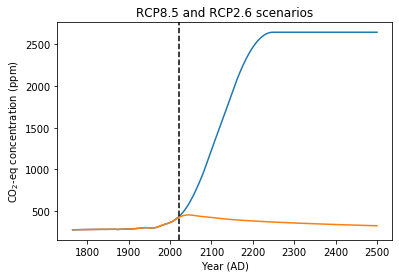

In [129]:
#Plot of RCP scenario's
plt.title('RCP8.5 and RCP2.6 scenarios')
plt.xlabel('Year (AD)')
plt.ylabel('CO$_2$-eq concentration (ppm)')
plt.plot(np.arange(1765,2501,1),RCP85list)
plt.plot(np.arange(1765,2501,1),RCP3list)
plt.axvline(x=2021,linestyle='--',color='black')

plt.show()

In [130]:
#A list to copy to the python file in the PlaSim model
totalppm.tolist()

[277.01467,
 277.8388,
 278.69351,
 278.74752,
 278.79644,
 278.84896,
 278.88421,
 278.92512,
 278.99387,
 279.06906,
 279.1513,
 279.2424,
 279.34214,
 279.44672,
 279.55094,
 279.65007,
 279.71846,
 279.78173,
 279.86798,
 279.95858,
 280.05821,
 280.16952,
 280.29117,
 280.41905,
 280.54845,
 280.67599,
 280.77766,
 280.87905,
 281.00453,
 281.12966,
 281.25415,
 281.37816,
 281.47794,
 281.57703,
 281.69873,
 281.7953,
 281.89146,
 281.96434,
 282.06097,
 282.20419,
 282.32288,
 282.41845,
 282.51428,
 282.63057,
 282.73903,
 282.8364,
 282.90004,
 282.9574,
 283.03571,
 283.11463,
 283.17382,
 283.21462,
 283.25897,
 283.32685,
 283.4149,
 283.49758,
 283.57508,
 283.62677,
 283.65484,
 283.70645,
 283.76004,
 283.8156,
 283.87272,
 283.93097,
 284.0128,
 283.96219,
 283.89979,
 283.8817,
 283.77007,
 283.66423,
 283.55955,
 283.36933,
 283.20262,
 283.15294,
 283.15861,
 283.1704,
 283.21078,
 283.30585,
 283.42935,
 283.57864,
 283.71288,
 283.88515,
 284.05105,
 284.22002,
 28

In [131]:
#Calculating the Global Mean Surface Temperature for each year
TSglobal=np.zeros(Nyears)
for year in range(Nyears):
    Sum=0
    for nlat in range(Nlat):
        Sum+=np.average(TS[0,year,nlat,:])*weights_T21[nlat]
    TSglobal[year]=Sum/np.sum(weights_T21)
    

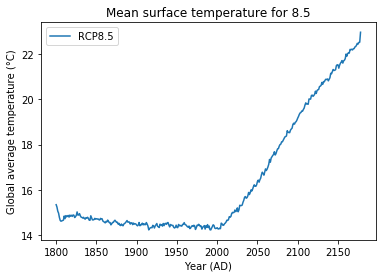

In [132]:
#Plot of GMST
plt.plot(yearlist,TSglobal-273.15,label='RCP8.5')

plt.title('Mean surface temperature for 8.5')
plt.xlabel('Year (AD)')
plt.ylabel('Global average temperature (°C)')

plt.legend()
plt.show()

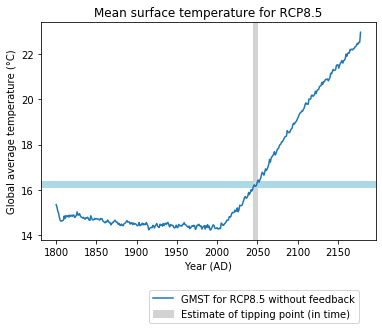

In 2045 the warming is 1.7641580704822672 relative to 1950 to 2000.
In 2050 the warming is 1.9955503140851647 relative to 1950 to 2000.


In [133]:
#Plot of GMST with tipping point analysis
plt.plot(yearlist,TSglobal-273.15,label='GMST for RCP8.5 without feedback')
plt.title('Mean surface temperature for RCP8.5')
plt.xlabel('Year (AD)')
plt.ylabel('Global average temperature (°C)')
plt.axhspan(ymin=289.2852671768301-273.15,ymax=289.516659420433-273.15,color='lightblue')
plt.axvspan(xmin=2045,xmax=2050,color='lightgrey',label='Estimate of tipping point (in time)')
plt.legend(bbox_to_anchor=(1.1, 0),borderaxespad=5)
plt.show()

print('In 2045 the warming is '+str(TSglobal[2045-1800]-np.average(TSglobal[1950-1800:2000-1800]))+' relative to 1950 to 2000.')
print('In 2050 the warming is '+str(TSglobal[2050-1800]-np.average(TSglobal[1950-1800:2000-1800]))+' relative to 1950 to 2000.')